In [ ]:
# Cell 1 — install packages (run once)
!pip install --quiet torchvision
# If you see version mismatch warnings for captum/torch, you might need to adjust versions to match your runtime torch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2 — mount drive and set paths

# EDIT THESE to match your Drive layout
DRIVE_ROOT = '/content/drive/MyDrive'
ZIP_PATH = f'{DRIVE_ROOT}/FDL_DS/snowy-clear-vgg.zip'   # path to your zip file
EXTRACT_DIR = '/content/dataset'            # where zip will be extracted
WEIGHTS_CYCLEGAN = f'{DRIVE_ROOT}/FDL_DS/G_AB_cycle_snow_to_clear.pth'   # cycle generator weights
WEIGHTS_FASTCUT = f'{DRIVE_ROOT}/FDL_DS/G_epoch_200_fastcut_snowy_to_clear.pth'     # fastcut generator weights
WEIGHTS_RESNET = f'{DRIVE_ROOT}/FDL_DS/G_epoch_200_resnet_snowy_to_clear.pth'       # resnet generator weights
OUTPUT_DIR = f'{DRIVE_ROOT}/xai_outputs'                      # where outputs will be saved

import os
os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("ZIP_PATH =", ZIP_PATH)
print("EXTRACT_DIR =", EXTRACT_DIR)
print("CycleGAN weights =", WEIGHTS_CYCLEGAN)
print("FastCUT weights =", WEIGHTS_FASTCUT)
print("ResNet weights =", WEIGHTS_RESNET)
print("OUTPUT_DIR =", OUTPUT_DIR)


ZIP_PATH = /content/drive/MyDrive/FDL_DS/snowy-clear-vgg.zip
EXTRACT_DIR = /content/dataset
CycleGAN weights = /content/drive/MyDrive/FDL_DS/G_AB_cycle_snow_to_clear.pth
FastCUT weights = /content/drive/MyDrive/FDL_DS/G_epoch_200_fastcut_snowy_to_clear.pth
ResNet weights = /content/drive/MyDrive/FDL_DS/G_epoch_200_resnet_snowy_to_clear.pth
OUTPUT_DIR = /content/drive/MyDrive/xai_outputs


In [ ]:
# Cell 3 — extract dataset zip (if already extracted this will overwrite/skip)
import zipfile, os

if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
    print("Extracted zip to", EXTRACT_DIR)
else:
    print("Zip file not found at", ZIP_PATH, "- if your dataset is already extracted, ignore this.")
# list a few files to confirm
sample_files = [f for f in os.listdir(EXTRACT_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]
print("Found", len(sample_files), "image files in", EXTRACT_DIR)

Extracted zip to /content/dataset
Found 0 image files in /content/dataset


In [ ]:
# ✅ Final Cell 4 — use only snowy images for generation
import torch, os, glob, random, numpy as np
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# preprocessing/postprocess - adjust IMAGE_SIZE to match your training resolution
IMAGE_SIZE = (256, 256)
preprocess = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
postprocess = lambda t: ((t.clamp(-1,1) + 1) / 2)  # maps [-1,1] -> [0,1]

# Parameters
N_GENERATE = 150   # generate 300 images per model
NUM_SAMPLES_LIME = 200
SHAP_NSAMPLES = 200
DATASET_DIR = EXTRACT_DIR
OUTPUT_DIR = OUTPUT_DIR

# ✅ Recursively collect all images, but filter only those inside 'snowy' subfolder
all_images = sorted(
    glob.glob(os.path.join(DATASET_DIR, "**", "*.jpg"), recursive=True)
    + glob.glob(os.path.join(DATASET_DIR, "**", "*.jpeg"), recursive=True)
    + glob.glob(os.path.join(DATASET_DIR, "**", "*.png"), recursive=True)
)

# Filter only snowy images
snowy_images = [p for p in all_images if "snow" in os.path.basename(os.path.dirname(p)).lower()]

assert len(snowy_images) > 0, f"No snowy images found under {DATASET_DIR}. Check your folder names."

# summary print
print(f"Found {len(snowy_images)} snowy images for generation.")
print(f"Example snowy folder: {os.path.dirname(snowy_images[0])}")

# shuffle and select first N_GENERATE
random.seed(42)
random.shuffle(snowy_images)
generate_list = snowy_images[:N_GENERATE]
print(f"Will generate {len(generate_list)} images (only snowy domain used).")

Device: cuda
Found 687 snowy images for generation.
Example snowy folder: /content/dataset/snowy
Will generate 150 images (only snowy domain used).


In [ ]:
# Cell — GeneratorCycleGAN (extracted & adapted from your CycleGAN code)
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class GeneratorCycleGAN(nn.Module):
    """
    CycleGAN-style ResNet generator adapted from your implementation.
    - in_c/out_c: input/output channels (default RGB)
    - n_blocks: number of ResBlocks (6 in your original code)
    - forward(x, return_features=False) -> out  OR  (out, feats)
      where feats is a list of encoder feature maps (collected after ReLU layers).
    """
    def __init__(self, in_c=3, out_c=3, n_blocks=6):
        super().__init__()
        # Encoder layers (we will collect features after ReLU layers)
        self.enc_layers = nn.ModuleList([
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
        ])

        # Middle ResNet blocks
        res_blocks = [ResBlock(256) for _ in range(n_blocks)]
        self.middle = nn.Sequential(*res_blocks)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_c, 7),
            nn.Tanh()
        )

    def forward(self, x, return_features=False):
        feats = []
        out = x
        # run encoder and collect feature maps at ReLU layers (same convention as FastCUT cell)
        for layer in self.enc_layers:
            out = layer(out)
            if isinstance(layer, nn.ReLU):
                feats.append(out)

        out = self.middle(out)
        out = self.decoder(out)

        if return_features:
            return out, feats
        return out

In [ ]:
# Cell A — GeneratorFastCUT (extracted/adapted from your FastCUT EncoderDecoder)
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

class GeneratorFastCUT(nn.Module):
    """
    Encoder-Resnet-Decoder style generator originally used in the FastCUT code you shared.
    Keeps the `return_features` flag so you can extract encoder features for PatchNCE or xAI.
    Input/Output range: same as original training pipeline (typically [-1,1] if you use Tanh).
    """
    def __init__(self, n_res_blocks=6, in_ch=3, ngf=64):
        super().__init__()
        # Encoder
        enc = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, ngf, kernel_size=7), nn.InstanceNorm2d(ngf), nn.ReLU(True),
            nn.Conv2d(ngf, ngf*2, kernel_size=3, stride=2, padding=1), nn.InstanceNorm2d(ngf*2), nn.ReLU(True),
            nn.Conv2d(ngf*2, ngf*4, kernel_size=3, stride=2, padding=1), nn.InstanceNorm2d(ngf*4), nn.ReLU(True)
        ]
        self.encoder = nn.Sequential(*enc)

        # Middle ResNet blocks
        res_blocks = [ResnetBlock(ngf*4) for _ in range(n_res_blocks)]
        self.middle = nn.Sequential(*res_blocks)

        # Decoder
        dec = [
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf), nn.ReLU(True),
            nn.ReflectionPad2d(3), nn.Conv2d(ngf, in_ch, kernel_size=7), nn.Tanh()
        ]
        self.decoder = nn.Sequential(*dec)

    def forward(self, x, return_features=False):
        """
        If return_features=True => returns (output, feats) where feats is a list of encoder feature maps
        (useful for PatchNCE / feature-based explanations).
        Otherwise returns output tensor only.
        """
        feats = []
        out = x
        for layer in self.encoder:
            out = layer(out)
            # collect feature maps at ReLU layers (same as your training code)
            if isinstance(layer, nn.ReLU):
                feats.append(out)
        out = self.middle(out)
        out_dec = self.decoder(out)
        if return_features:
            return out_dec, feats
        return out_dec

In [ ]:
# ==== GeneratorResNet: architecture for your third model ====

import torch
import torch.nn as nn

class ResBlock(nn.Module):
    """Residual block: Conv -> IN -> ReLU -> Conv -> IN with skip connection."""
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    """
    ResNet-style generator (Encoder -> ResBlocks -> Decoder)
    Used for the 3rd model with VGG perceptual loss (during training only).
    """
    def __init__(self, in_ch=3, out_ch=3, n_res_blocks=9, ngf=64):
        super().__init__()

        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, ngf, 7), nn.InstanceNorm2d(ngf), nn.ReLU(True),

            nn.Conv2d(ngf, ngf*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf*2), nn.ReLU(True),

            nn.Conv2d(ngf*2, ngf*4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(ngf*4), nn.ReLU(True)
        )

        # ----- Middle ResNet Blocks -----
        self.middle = nn.Sequential(
            *[ResBlock(ngf*4) for _ in range(n_res_blocks)]
        )

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(ngf), nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, out_ch, 7),
            nn.Tanh()
        )

    def forward(self, x, return_features=False):
        feats = []
        out = x

        # record encoder ReLU features (keeps API consistent with other generators)
        for layer in self.encoder:
            out = layer(out)
            if isinstance(layer, nn.ReLU):
                feats.append(out)

        out = self.middle(out)
        out = self.decoder(out)

        if return_features:
            return out, feats
        return out

In [ ]:
# Cell 7 — load weights and generate N_GENERATE images (saves to Drive)
import torch
from torchvision.utils import save_image
import os

# instantiate

G_cycle = GeneratorCycleGAN().to(device)
G_fast = GeneratorFastCUT().to(device)
G_resnet = GeneratorResNet().to(device)

# helper to load weights safely
def try_load_weights(model, path):
    if os.path.exists(path):
        try:
            model.load_state_dict(torch.load(path, map_location=device))
            print("Loaded weights:", path)
        except Exception as e:
            print("Failed to load weights:", path, " — error:", e)
    else:
        print("Weight file not found:", path, " — using current model instance (likely placeholder).")

try_load_weights(G_cycle, WEIGHTS_CYCLEGAN)
try_load_weights(G_fast, WEIGHTS_FASTCUT)
try_load_weights(G_resnet, WEIGHTS_RESNET)

G_cycle.eval(); G_fast.eval(); G_resnet.eval() # Ensure all models are in eval mode

# generation function
def generate_and_save(generator, prefix, input_paths, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    saved = []
    with torch.no_grad():
        for i, p in enumerate(input_paths):
            pil = Image.open(p).convert('RGB')
            t = preprocess(pil).unsqueeze(0).to(device)
            out = generator(t)
            out_p = postprocess(out.detach().cpu())
            save_path = os.path.join(out_dir, f"{prefix}_out_{i:04d}.png")
            save_image(out_p, save_path)
            saved.append(save_path)
            if (i+1) % 50 == 0:
                print(f"{prefix}: generated {i+1}/{len(input_paths)}")
    print(f"{prefix}: finished generating {len(saved)} images to {out_dir}")
    return saved

# run generation (these will be saved to OUTPUT_DIR/cycle/ and OUTPUT_DIR/fastcut/)
cycle_out_dir = os.path.join(OUTPUT_DIR, 'cycle_generated')
fastcut_out_dir = os.path.join(OUTPUT_DIR, 'fastcut_generated')
resnet_out_dir = os.path.join(OUTPUT_DIR, 'resnet_generated')

cycle_saved = generate_and_save(G_cycle, 'cycle', generate_list, cycle_out_dir)
fastcut_saved = generate_and_save(G_fast, 'fastcut', generate_list, fastcut_out_dir)
resnet_saved = generate_and_save(G_resnet, 'resnet', generate_list, resnet_out_dir)

Failed to load weights: /content/drive/MyDrive/FDL_DS/G_AB_cycle_snow_to_clear.pth  — error: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Generator was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.Generator])` or the `torch.serialization.safe_globals([__main__.Generator])` context manager to allowlist this global if you trust this class/function.

Check the do

Using this single input image for xAI (same for all models): /content/dataset/snowy/01c6a5ce-7dba0d93.jpg
Saved single outputs: /content/drive/MyDrive/xai_outputs/single_cycle_out.png /content/drive/MyDrive/xai_outputs/single_fast_out.png /content/drive/MyDrive/xai_outputs/single_resnet_out.png


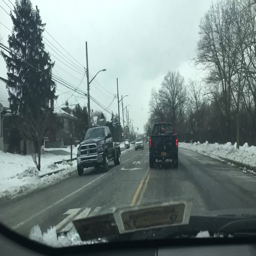

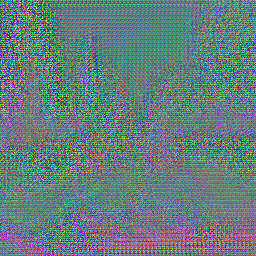

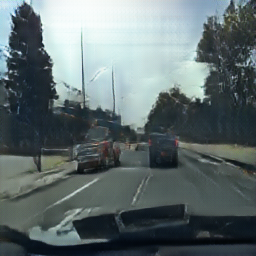

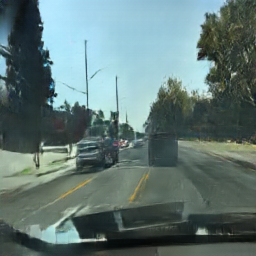

In [ ]:
# Cell 8 — pick the one image to use for all xAI analyses
# We'll use the first image from the generated set (or you can pick any index)
xai_index = 0   # change if you want a different image from the generated set
input_for_xai = generate_list[xai_index]   # original input image path (from dataset)
print("Using this single input image for xAI (same for all models):", input_for_xai)

# Run both generators on this single image and keep tensors for analysis
orig_pil = Image.open(input_for_xai).convert('RGB').resize(IMAGE_SIZE)
inp_tensor = preprocess(orig_pil).unsqueeze(0).to(device)

G_cycle.eval(); G_fast.eval()
with torch.no_grad():
    out_cycle = G_cycle(inp_tensor)
    out_fast  = G_fast(inp_tensor)
    out_resnet = G_resnet(inp_tensor)

# Save the generated images (single)
single_cycle_path = os.path.join(OUTPUT_DIR, 'single_cycle_out.png')
single_fast_path  = os.path.join(OUTPUT_DIR, 'single_fast_out.png')
single_resnet_path  = os.path.join(OUTPUT_DIR, 'single_resnet_out.png')
save_image(postprocess(out_cycle.detach().cpu()), single_cycle_path)
save_image(postprocess(out_fast.detach().cpu()), single_fast_path)
save_image(postprocess(out_resnet.detach().cpu()), single_resnet_path)
print("Saved single outputs:", single_cycle_path, single_fast_path, single_resnet_path)

# quick display inline (optional)
from IPython.display import display
display(orig_pil)
display(Image.open(single_cycle_path))
display(Image.open(single_fast_path))
display(Image.open(single_resnet_path))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

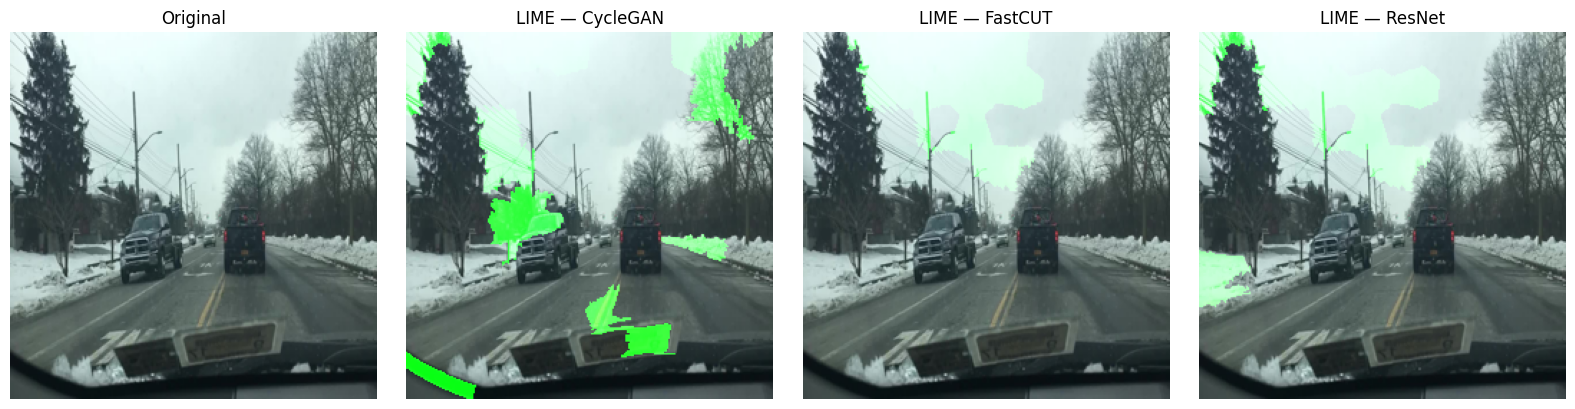

Saved LIME side-by-side to: /content/drive/MyDrive/xai_outputs/lime_side_by_side_all3.png


In [ ]:
# Fixed LIME cell — runs for CycleGAN, FastCUT, ResNet and plots in correct order
!pip install --quiet lime
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from PIL import Image

# parameters (reduce num samples for faster debugging)
NUM_SAMPLES_LIME = NUM_SAMPLES_LIME if 'NUM_SAMPLES_LIME' in globals() else 200

# prepare references: full generator outputs for the chosen image (as numpy arrays)
with torch.no_grad():
    ref_cycle = out_cycle.detach().cpu().squeeze(0).numpy().transpose(1,2,0)   # HWC in [-1,1]
    ref_fast  = out_fast.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    ref_resnet= out_resnet.detach().cpu().squeeze(0).numpy().transpose(1,2,0)

def make_lime_fn_for_generator(generator, ref_np):
    def fn(imgs):
        results = []
        for im in imgs:
            pil = Image.fromarray(im.astype('uint8'))
            t = preprocess(pil).unsqueeze(0).to(device)
            with torch.no_grad():
                out = generator(t)
                if isinstance(out, (tuple, list)):
                    out = out[0]
            out_np = out.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
            out_norm = (out_np + 1)/2
            ref_norm = (ref_np + 1)/2
            score = -np.mean(np.abs(out_norm - ref_norm))
            results.append([score])
        return np.array(results)
    return fn

explainer = lime_image.LimeImageExplainer()
np_img = np.array(orig_pil.resize(IMAGE_SIZE)).astype(np.uint8)

# CycleGAN
fn_cycle = make_lime_fn_for_generator(G_cycle, ref_cycle)
exp_cycle = explainer.explain_instance(np_img,
                                      classifier_fn=fn_cycle,
                                      top_labels=1,
                                      hide_color=0,
                                      num_samples=NUM_SAMPLES_LIME,
                                      segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10))
lbl_cycle = exp_cycle.top_labels[0]
lime_img_cycle, mask_cycle = exp_cycle.get_image_and_mask(lbl_cycle, positive_only=False, num_features=10, hide_rest=False)

# FastCUT
fn_fast = make_lime_fn_for_generator(G_fast, ref_fast)
exp_fast = explainer.explain_instance(np_img,
                                     classifier_fn=fn_fast,
                                     top_labels=1,
                                     hide_color=0,
                                     num_samples=NUM_SAMPLES_LIME,
                                     segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10))
lbl_fast = exp_fast.top_labels[0]
lime_img_fast, mask_fast = exp_fast.get_image_and_mask(lbl_fast, positive_only=False, num_features=10, hide_rest=False)

# ResNet
fn_resnet = make_lime_fn_for_generator(G_resnet, ref_resnet)
exp_resnet = explainer.explain_instance(np_img,
                                       classifier_fn=fn_resnet,
                                       top_labels=1,
                                       hide_color=0,
                                       num_samples=NUM_SAMPLES_LIME,
                                       segmentation_fn=lambda x: slic(x, n_segments=100, compactness=10))
lbl_resnet = exp_resnet.top_labels[0]
lime_img_resnet, mask_resnet = exp_resnet.get_image_and_mask(lbl_resnet, positive_only=False, num_features=10, hide_rest=False)

# Save & plot: Original | LIME CycleGAN | LIME FastCUT | LIME ResNet
plt.figure(figsize=(16,4))
plt.subplot(1,4,1); plt.title('Original'); plt.axis('off'); plt.imshow(orig_pil.resize(IMAGE_SIZE))
plt.subplot(1,4,4); plt.title('LIME — ResNet'); plt.axis('off'); plt.imshow(lime_img_resnet)
plt.subplot(1,4,2); plt.title('LIME — CycleGAN'); plt.axis('off'); plt.imshow(lime_img_cycle)
plt.subplot(1,4,3); plt.title('LIME — FastCUT'); plt.axis('off'); plt.imshow(lime_img_fast)
plt.tight_layout()
lime_side_path = os.path.join(OUTPUT_DIR, 'lime_side_by_side_all3.png')
plt.savefig(lime_side_path, bbox_inches='tight', pad_inches=0.1)
plt.show()
print("Saved LIME side-by-side to:", lime_side_path)

Running SHAP for CycleGAN...


  0%|          | 0/1 [00:00<?, ?it/s]

Running SHAP for FastCUT...


  0%|          | 0/1 [00:00<?, ?it/s]

Running SHAP for ResNet...


  0%|          | 0/1 [00:00<?, ?it/s]

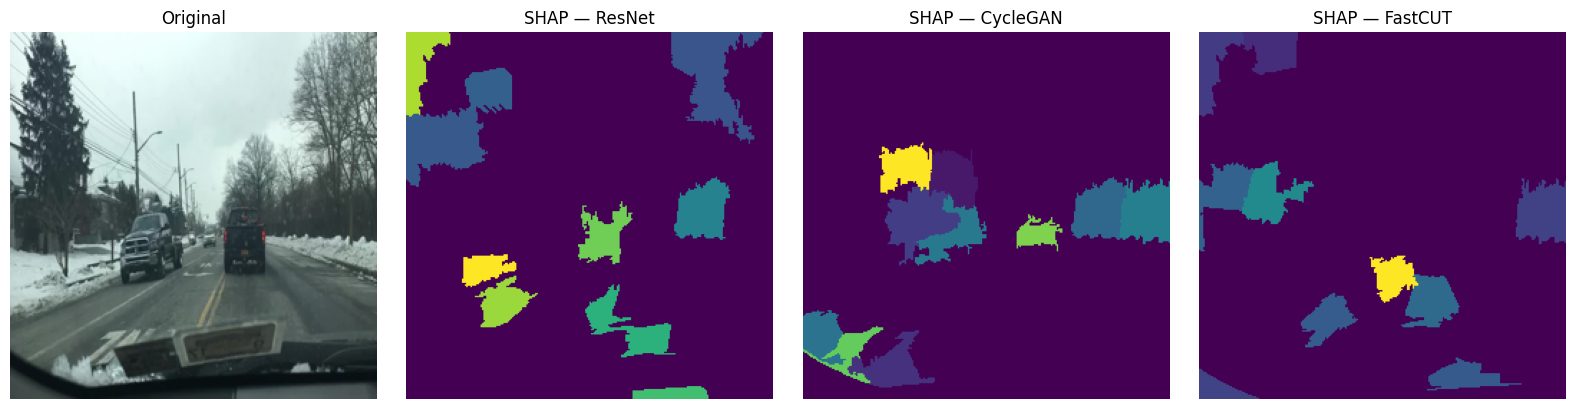

Saved SHAP visualization to: /content/drive/MyDrive/xai_outputs/shap_side_by_side_all3.png


In [ ]:
# Fixed SHAP cell — runs for CycleGAN, FastCUT, ResNet and plots Original | Cycle | FastCUT | ResNet
import shap, cv2
import numpy as np
from skimage.segmentation import slic
from PIL import Image
import matplotlib.pyplot as plt

# parameters (adjust if already defined)
N_SUPERPIXELS = 100
SHAP_NSAMPLES = SHAP_NSAMPLES if 'SHAP_NSAMPLES' in globals() else 200

# helper background
def make_shap_background(pil_img, n=5):
    arrs = []
    for i in range(n):
        a = np.array(pil_img).astype(np.uint8)
        k = 3 + 2*i
        b = cv2.GaussianBlur(a, (k,k), 0)
        arrs.append(b)
    return np.stack(arrs).astype(np.float64)

# prepare segmentation and background
np_img = np.array(orig_pil.resize(IMAGE_SIZE)).astype(np.uint8)
segments = slic(np_img, n_segments=N_SUPERPIXELS, compactness=10)
bg_images = make_shap_background(orig_pil, n=5)
bg_flat = bg_images.reshape(bg_images.shape[0], -1).astype(np.float64)

# wrapper that returns scalar score for flattened images
def make_shap_wrapper(generator, ref_np):
    def fn(X):
        outs = []
        for i in range(X.shape[0]):
            arr = X[i].reshape((IMAGE_SIZE[1], IMAGE_SIZE[0], 3)).astype(np.uint8)
            pil = Image.fromarray(arr)
            t = preprocess(pil).unsqueeze(0).to(device)
            with torch.no_grad():
                out = generator(t)
                if isinstance(out, (tuple, list)):
                    out = out[0]
            out_np = out.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
            out_norm = (out_np + 1)/2.0
            ref_norm = (ref_np + 1)/2.0
            score = -np.mean(np.abs(out_norm - ref_norm))
            outs.append(score)
        return np.array(outs).reshape(-1,1)
    return fn

# ensure ref outputs exist (computed earlier)
with torch.no_grad():
    # they should be available as out_cycle/out_fast/out_resnet; otherwise compute
    try:
        ref_cycle = out_cycle.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    except:
        ref_cycle = G_cycle(preprocess(orig_pil).unsqueeze(0).to(device)).detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    try:
        ref_fast = out_fast.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    except:
        ref_fast = G_fast(preprocess(orig_pil).unsqueeze(0).to(device)).detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    try:
        ref_resnet = out_resnet.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
    except:
        ref_resnet = G_resnet(preprocess(orig_pil).unsqueeze(0).to(device)).detach().cpu().squeeze(0).numpy().transpose(1,2,0)

# run shap for each model (this can take a while)
print("Running SHAP for CycleGAN...")
explainer_cycle = shap.KernelExplainer(make_shap_wrapper(G_cycle, ref_cycle), bg_flat, link="identity")
x_flat = np.array(orig_pil.resize(IMAGE_SIZE)).astype(np.uint8).reshape(1, -1).astype(np.float64)
shap_vals_cycle = explainer_cycle.shap_values(x_flat, nsamples=SHAP_NSAMPLES)
if isinstance(shap_vals_cycle, list):
    shap_vals_cycle = shap_vals_cycle[0]
shap_map_cycle = shap_vals_cycle.reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3)
perpix_cycle = np.abs(shap_map_cycle).sum(axis=2)
sp_heat_cycle = np.zeros_like(perpix_cycle, dtype=np.float32)
for sp_id in np.unique(segments):
    mask = (segments == sp_id)
    sp_heat_cycle[mask] = np.mean(perpix_cycle[mask])
sp_heat_cycle = (sp_heat_cycle - sp_heat_cycle.min()) / (sp_heat_cycle.max() - sp_heat_cycle.min() + 1e-9)

print("Running SHAP for FastCUT...")
explainer_fast = shap.KernelExplainer(make_shap_wrapper(G_fast, ref_fast), bg_flat, link="identity")
shap_vals_fast = explainer_fast.shap_values(x_flat, nsamples=SHAP_NSAMPLES)
if isinstance(shap_vals_fast, list):
    shap_vals_fast = shap_vals_fast[0]
shap_map_fast = shap_vals_fast.reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3)
perpix_fast = np.abs(shap_map_fast).sum(axis=2)
sp_heat_fast = np.zeros_like(perpix_fast, dtype=np.float32)
for sp_id in np.unique(segments):
    mask = (segments == sp_id)
    sp_heat_fast[mask] = np.mean(perpix_fast[mask])
sp_heat_fast = (sp_heat_fast - sp_heat_fast.min()) / (sp_heat_fast.max() - sp_heat_fast.min() + 1e-9)

print("Running SHAP for ResNet...")
explainer_resnet = shap.KernelExplainer(make_shap_wrapper(G_resnet, ref_resnet), bg_flat, link="identity")
shap_vals_resnet = explainer_resnet.shap_values(x_flat, nsamples=SHAP_NSAMPLES)
if isinstance(shap_vals_resnet, list):
    shap_vals_resnet = shap_vals_resnet[0]
shap_map_resnet = shap_vals_resnet.reshape(IMAGE_SIZE[1], IMAGE_SIZE[0], 3)
perpix_resnet = np.abs(shap_map_resnet).sum(axis=2)
sp_heat_resnet = np.zeros_like(perpix_resnet, dtype=np.float32)
for sp_id in np.unique(segments):
    mask = (segments == sp_id)
    sp_heat_resnet[mask] = np.mean(perpix_resnet[mask])
sp_heat_resnet = (sp_heat_resnet - sp_heat_resnet.min()) / (sp_heat_resnet.max() - sp_heat_resnet.min() + 1e-9)

# Plot: Original | ResNet | CycleGAN | FastCUT
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title('Original')
plt.axis('off')
plt.imshow(orig_pil.resize(IMAGE_SIZE))

plt.subplot(1,4,2)
plt.title('SHAP — ResNet')
plt.axis('off')
plt.imshow(sp_heat_resnet, cmap='viridis')

plt.subplot(1,4,3)
plt.title('SHAP — CycleGAN')
plt.axis('off')
plt.imshow(sp_heat_cycle, cmap='viridis')

plt.subplot(1,4,4)
plt.title('SHAP — FastCUT')
plt.axis('off')
plt.imshow(sp_heat_fast, cmap='viridis')

plt.tight_layout()
shap_side_path = os.path.join(OUTPUT_DIR, 'shap_side_by_side_all3.png')
plt.savefig(shap_side_path, bbox_inches='tight', pad_inches=0.1)
plt.show()

print("Saved SHAP visualization to:", shap_side_path)

Computing occ for ResNet...
Computing occ for CycleGAN...
Computing occ for FastCUT...


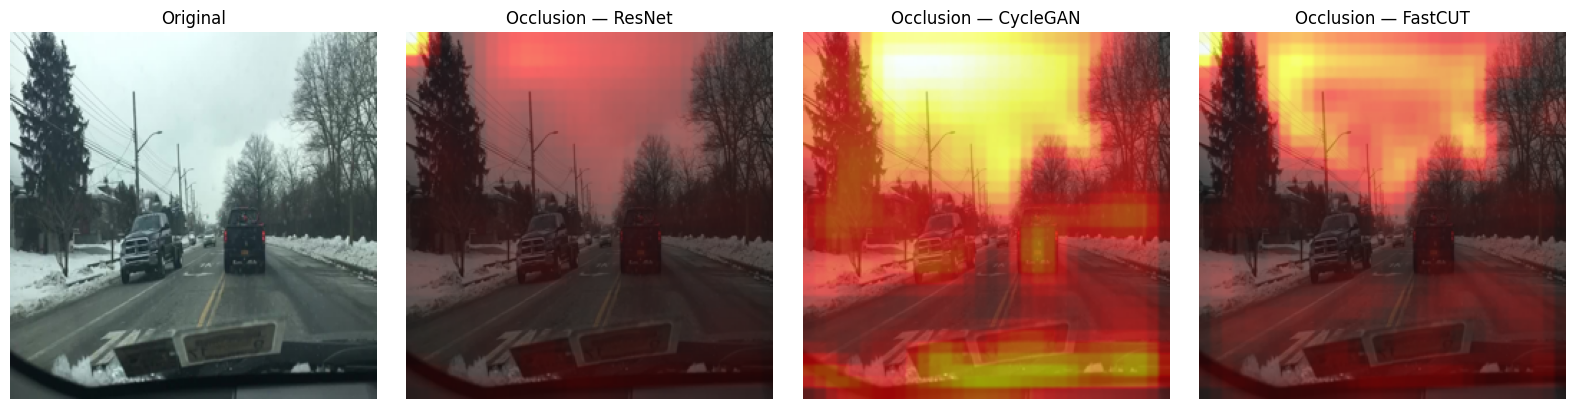

Saved Occlusion visualization to: /content/drive/MyDrive/xai_outputs/occlusion_side_by_side_all3.png


In [ ]:
# Fixed Occlusion cell — compute for ResNet, CycleGAN, FastCUT and plot Original | ResNet | CycleGAN | FastCUT
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

# SETTINGS (tune for speed vs resolution)
patch_size = 16    # smaller => higher spatial resolution
stride = 8         # sliding stride
blur_sigma = 1.0   # gaussian smoothing of final heatmap
overlay_alpha = 0.6

# Ensure IMAGE_SIZE is (W,H)
W, H = IMAGE_SIZE

def occlusion_map(generator, inp_pil, patch_size=16, stride=8):
    # inp_pil: PIL image (any size) -> will be resized to IMAGE_SIZE for processing
    inp_resized = inp_pil.resize((W, H))
    base = np.array(inp_resized).astype(np.uint8)  # HxWx3
    with torch.no_grad():
        t0 = preprocess(inp_resized).unsqueeze(0).to(device)
        out_ref = generator(t0)
        if isinstance(out_ref, (tuple, list)):
            out_ref = out_ref[0]
        ref_out = out_ref.detach().cpu().squeeze(0).numpy().transpose(1,2,0)  # HWC [-1,1]
        ref_norm = (ref_out + 1.0) / 2.0

    heat = np.zeros((H, W), dtype=np.float32)
    counts = np.zeros((H, W), dtype=np.int32)

    # slide
    for y in range(0, H, stride):
        for x in range(0, W, stride):
            x1, y1 = x, y
            x2, y2 = min(x+patch_size, W), min(y+patch_size, H)
            pert = base.copy()
            pert[y1:y2, x1:x2, :] = 127
            pil_pert = Image.fromarray(pert)
            t = preprocess(pil_pert).unsqueeze(0).to(device)
            with torch.no_grad():
                out_p = generator(t)
                if isinstance(out_p, (tuple, list)):
                    out_p = out_p[0]
            out_np = out_p.detach().cpu().squeeze(0).numpy().transpose(1,2,0)
            out_norm = (out_np + 1.0) / 2.0
            score = np.mean(np.abs(out_norm - ref_norm))
            heat[y1:y2, x1:x2] += score
            counts[y1:y2, x1:x2] += 1

    counts[counts == 0] = 1
    heat = heat / counts
    heat = heat - heat.min()
    if heat.max() > 0:
        heat = heat / heat.max()
    if blur_sigma > 0:
        heat = gaussian_filter(heat, sigma=blur_sigma)
    return heat

print("Computing occ for ResNet...")
occ_resnet = occlusion_map(G_resnet, orig_pil, patch_size=patch_size, stride=stride)
print("Computing occ for CycleGAN...")
occ_cycle  = occlusion_map(G_cycle,  orig_pil, patch_size=patch_size, stride=stride)
print("Computing occ for FastCUT...")
occ_fast   = occlusion_map(G_fast,   orig_pil, patch_size=patch_size, stride=stride)

# overlay helper: expects heat of shape (H,W) and returns uint8 image same size as IMAGE_SIZE
def overlay_heat_on_image(img_pil, heat, cmap='hot', alpha=0.6):
    img_resized = img_pil.resize((W, H))
    # cv2.resize expects dsize as (width, height)
    heat_resized = cv2.resize(heat, (W, H))
    heat_rgb = plt.get_cmap(cmap)(heat_resized)[:,:,:3]  # HxWx3 float
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    overlay = (1-alpha)*img_arr + alpha*heat_rgb
    overlay = np.clip(overlay, 0, 1)
    return (overlay * 255).astype(np.uint8)

overlay_resnet = overlay_heat_on_image(orig_pil, occ_resnet, cmap='hot', alpha=overlay_alpha)
overlay_cycle  = overlay_heat_on_image(orig_pil, occ_cycle, cmap='hot', alpha=overlay_alpha)
overlay_fast   = overlay_heat_on_image(orig_pil, occ_fast, cmap='hot', alpha=overlay_alpha)

# Save images (optional)
os.makedirs(OUTPUT_DIR, exist_ok=True)
plt.imsave(os.path.join(OUTPUT_DIR, 'occ_resnet_heat.png'), occ_resnet, cmap='hot')
plt.imsave(os.path.join(OUTPUT_DIR, 'occ_cycle_heat.png'), occ_cycle, cmap='hot')
plt.imsave(os.path.join(OUTPUT_DIR, 'occ_fast_heat.png'), occ_fast, cmap='hot')
Image.fromarray(overlay_resnet).save(os.path.join(OUTPUT_DIR, 'occ_resnet_overlay.png'))
Image.fromarray(overlay_cycle).save(os.path.join(OUTPUT_DIR, 'occ_cycle_overlay.png'))
Image.fromarray(overlay_fast).save(os.path.join(OUTPUT_DIR, 'occ_fast_overlay.png'))

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.axis("off")
plt.imshow(orig_pil.resize((W, H)))

plt.subplot(1,4,2)
plt.title("Occlusion — ResNet")
plt.axis("off")
plt.imshow(overlay_resnet)

plt.subplot(1,4,3)
plt.title("Occlusion — CycleGAN")
plt.axis("off")
plt.imshow(overlay_cycle)

plt.subplot(1,4,4)
plt.title("Occlusion — FastCUT")
plt.axis("off")
plt.imshow(overlay_fast)

plt.tight_layout()
final_occ_path = os.path.join(OUTPUT_DIR, "occlusion_side_by_side_all3.png")
plt.savefig(final_occ_path, bbox_inches="tight", pad_inches=0.05)
plt.show()

print("Saved Occlusion visualization to:", final_occ_path)

Saved 3x4 XAI grid to: /content/drive/MyDrive/xai_outputs/xai_grid_3x4.png


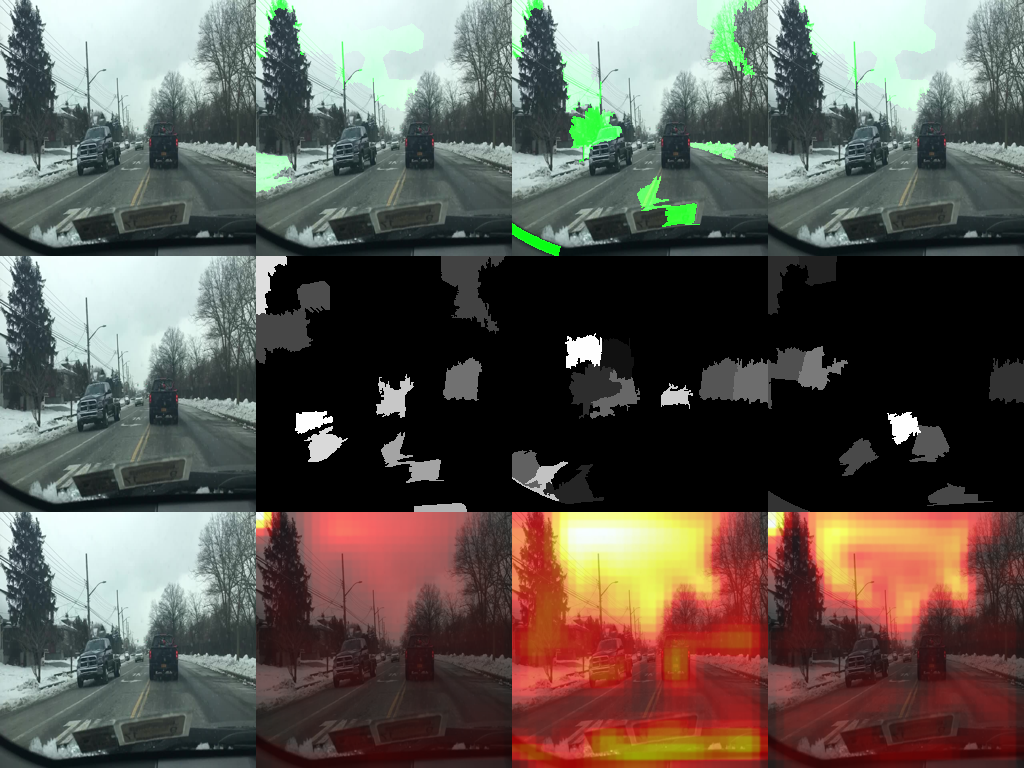

In [ ]:
# Build compact 3x4 grid: rows = [LIME, SHAP, Occlusion], cols = [Original, ResNet, CycleGAN, FastCUT]
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

# User-tunable tile size
TILE = 256   # px per tile (change to 224 for narrower paper-friendly figure)
OUT_PATH = os.path.join(OUTPUT_DIR, 'xai_grid_3x4.png')

# Helper: convert various inputs into RGB PIL tile of size TILE x TILE
def to_tile(img, size=(TILE, TILE), cmap=None):
    if img is None:
        return Image.new('RGB', size, (128,128,128))
    # If PIL image
    if isinstance(img, Image.Image):
        return img.convert('RGB').resize(size)
    # If numpy array
    arr = np.array(img)
    # floats in [0,1] -> scale to 0..255
    if arr.dtype in (np.float32, np.float64):
        if arr.max() <= 1.0:
            arr = (arr * 255.0).astype(np.uint8)
        else:
            arr = (arr * 255.0).astype(np.uint8) if arr.max()<=1.0 else arr.astype(np.uint8)
    # grayscale -> make 3-channel
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=2)
    # heatmap floats (0..1) with cmap
    if cmap is not None and arr.ndim == 2:
        cmap_func = plt.get_cmap(cmap)
        arr_rgb = (cmap_func(arr)[:,:,:3] * 255).astype(np.uint8)
        return Image.fromarray(arr_rgb).convert('RGB').resize(size)
    # ensure uint8 HxWx3
    if arr.ndim == 3 and arr.shape[2] == 3:
        return Image.fromarray(arr.astype(np.uint8)).convert('RGB').resize(size)
    # fallback
    return Image.new('RGB', size, (128,128,128))

# Prepare source tiles (Original repeated in first column)
orig_tile = to_tile(orig_pil, size=(TILE, TILE))

# ------- LIME tiles (expected as arrays or PIL) -------
lime_res = globals().get('lime_img_resnet', None)
lime_cycle = globals().get('lime_img_cycle', None)
lime_fast = globals().get('lime_img_fast', None)

tile_lime_orig  = orig_tile
tile_lime_res   = to_tile(lime_res)
tile_lime_cycle = to_tile(lime_cycle)
tile_lime_fast  = to_tile(lime_fast)

# ------- SHAP tiles (expected as float heatmaps sp_heat_*, 0..1) -------
sp_res = globals().get('sp_heat_resnet', None)
sp_cycle = globals().get('sp_heat_cycle', None)
sp_fast = globals().get('sp_heat_fast', None)

tile_shap_orig  = orig_tile
tile_shap_res   = to_tile(sp_res, cmap='viridis')
tile_shap_cycle = to_tile(sp_cycle, cmap='viridis')
tile_shap_fast  = to_tile(sp_fast, cmap='viridis')

# ------- Occlusion tiles: prefer overlay_* (RGB) else occ_* heatmaps -------
ov_res = globals().get('overlay_resnet', None)
ov_cycle = globals().get('overlay_cycle', None)
ov_fast = globals().get('overlay_fast', None)

occ_res_arr = globals().get('occ_resnet', None)
occ_cycle_arr = globals().get('occ_cycle', None)
occ_fast_arr = globals().get('occ_fast', None)

def occ_tile(overlay_img, occ_arr):
    if overlay_img is not None:
        return to_tile(overlay_img)
    if occ_arr is not None:
        return to_tile(occ_arr, cmap='hot')
    return None

tile_occ_orig  = orig_tile
tile_occ_res   = occ_tile(ov_res, occ_res_arr)
tile_occ_cycle = occ_tile(ov_cycle, occ_cycle_arr)
tile_occ_fast  = occ_tile(ov_fast, occ_fast_arr)

# Ensure none are None
rows = [
    [tile_lime_orig, tile_lime_res, tile_lime_cycle, tile_lime_fast],
    [tile_shap_orig, tile_shap_res, tile_shap_cycle, tile_shap_fast],
    [tile_occ_orig,  tile_occ_res,  tile_occ_cycle,  tile_occ_fast]
]

def ensure_tile(t):
    return t if t is not None else Image.new('RGB', (TILE, TILE), (128,128,128))

rows = [[ensure_tile(t) for t in row] for row in rows]

# Compose 3 rows x 4 cols with no spacing
grid_w = 4 * TILE
grid_h = 3 * TILE
grid = Image.new('RGB', (grid_w, grid_h))
for r_idx, row in enumerate(rows):
    for c_idx, tile in enumerate(row):
        grid.paste(tile, (c_idx * TILE, r_idx * TILE))

# Save & display
os.makedirs(OUTPUT_DIR, exist_ok=True)
grid.save(OUT_PATH, quality=95)
print("Saved 3x4 XAI grid to:", OUT_PATH)
display(grid)
